In [1]:
import sys

sys.path.append('../GraphStructureLearning')

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pickle
import matplotlib.pyplot as plt

from glob import glob
import yaml
from easydict import EasyDict as edict

In [3]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch_geometric.utils.random import erdos_renyi_graph

In [4]:
from utils.utils import build_fully_connected_edge_idx

In [5]:
config_file = glob('./config/GTS/CCN_Project/test.yaml')[0]
config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
dataset_conf = config.dataset

In [6]:
dataset = pickle.load(open('./data/CCN/monkeydata.pickle', 'rb'))

In [7]:
dataset = dataset.reshape(-1, 101, 742).numpy()

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
# scaler_x = StandardScaler()
# scaler_y = StandardScaler()
# scaler_z = StandardScaler()

# scaler_x.fit(dataset[:, -3, :])
# scaler_y.fit(dataset[:, -2, :])
# scaler_z.fit(dataset[:, -1, :])

# dataset[:, -3, :] = scaler_x.transform(dataset[:, -3, :])
# dataset[:, -2, :] = scaler_y.transform(dataset[:, -2, :])
# dataset[:, -1, :] = scaler_z.transform(dataset[:, -1, :])

In [10]:
train_x = dataset[:80, :98, :]
train_y = dataset[:80, 98:, :]

valid_x = dataset[80:90, :98, :]
valid_y = dataset[80:90, 98:, :]

test_x = dataset[90:, :98, :]
test_y = dataset[90:, 98:, :]

In [11]:
edge_index = erdos_renyi_graph(config.nodes_num, 0.01)

/opt/anaconda3/envs/GraphStructureLearning/lib/python3.9/site-packages/torch_geometric/utils/random.py:22: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idx = torch.combinations(torch.arange(num_nodes), r=2)


In [12]:
train_x.shape

(80, 98, 742)

In [13]:
def prepare_dataset(dataset, dataset_conf, edge_index):
    x = dataset[0]
    y = dataset[1]
    
#     valid_sampling_locations = []
#     valid_sampling_locations += [
#         (dataset_conf.window_size + i)
#         for i in range(dataset_conf.total_time_length - dataset_conf.window_size + 1)
#         if (i % dataset_conf.slide) == 0
#     ]

    data_list = []

    for trial in range(len(x)):
        spike_inputs = x[trial, :, :]
        target_trajectory = y[trial, :, :]
        data_item = Data(x=torch.FloatTensor(spike_inputs), edge_index=edge_index, y=torch.FloatTensor(target_trajectory))
        data_list.append(data_item)

    return data_list

In [14]:
dataset_conf.window_size = 202
dataset_conf.slide = 10

In [15]:
train_dataset = prepare_dataset([train_x, train_y], dataset_conf, edge_index)
valid_dataset = prepare_dataset([valid_x, valid_y], dataset_conf, edge_index)
test_dataset = prepare_dataset([test_x, test_y], dataset_conf, edge_index)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [72]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, config):
        super(RecurrentGCN, self).__init__()
        self.num_nodes = config.nodes_num
        self.nodes_feas = config.node_features

        self.kernel_size = config.embedding.kernel_size
        self.stride = config.embedding.stride
        self.conv1_dim = config.embedding.conv1_dim
        self.conv2_dim = config.embedding.conv2_dim

        self.embedding_dim = config.embedding.embedding_dim

        self.conv1 = torch.nn.Conv1d(self.nodes_feas, self.conv1_dim, self.kernel_size, stride=self.stride)
        self.conv2 = torch.nn.Conv1d(self.conv1_dim, self.conv2_dim, self.kernel_size, stride=self.stride)

        self.bn1 = torch.nn.BatchNorm1d(self.conv1_dim)
        self.bn2 = torch.nn.BatchNorm1d(self.conv2_dim)
        
        self.recurrent = DCRNN(self.conv2_dim, self.conv2_dim, 1)
        
        self.conv3 = torch.nn.Conv1d(1, 1, self.conv2_dim, stride=1)
        
        self.out_1 = torch.nn.Linear(98, 742)
        self.out_2 = torch.nn.Linear(98, 742)
        self.out_3 = torch.nn.Linear(98, 742)

    def forward(self, x, edge_index, hidden_state):
        batch_nodes = x.shape[0]
        if len(x.shape) == 2:
            inputs = x.reshape(batch_nodes, 1, -1)
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
#         print(x.shape)

        x = x.view(batch_nodes, -1) 
#         print(x.shape)
        
        
        h = self.recurrent(x, edge_index, H=hidden_state)
        h = F.relu(h)
#         print(h.shape)
        
        h_ = h.view(batch_nodes, 1, self.conv2_dim)
#         print(h_.shape)
        forecast_h = self.conv3(h_)
        forecast_h = F.relu(forecast_h)
#         print(forecast_h.shape)
        
        forecast_h = forecast_h.view(-1)
#         print(forecast_h.shape)
        
        out_x = self.out_1(forecast_h)
        out_y = self.out_2(forecast_h)
        out_z = self.out_3(forecast_h)
        
        
        return out_x, out_y, out_z, h

In [73]:
config.embedding.kernel_size=80
config.embedding.conv2_dim = 64

In [79]:
from tqdm import tqdm

model = RecurrentGCN(config)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    cost = 0
    for data in train_loader:
        H = None
        out_x, out_y, out_z, H = model(data.x, data.edge_index, H)

        cost_x = torch.mean((out_x-data.y[0, :])**2)
        cost_y = torch.mean((out_y-data.y[1, :])**2)
        cost_z = torch.mean((out_z-data.y[2, :])**2)
        
        cost += cost + cost_x + cost_y + cost_z
        
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|███████████████████████████████████████████| 50/50 [00:42<00:00,  1.18it/s]


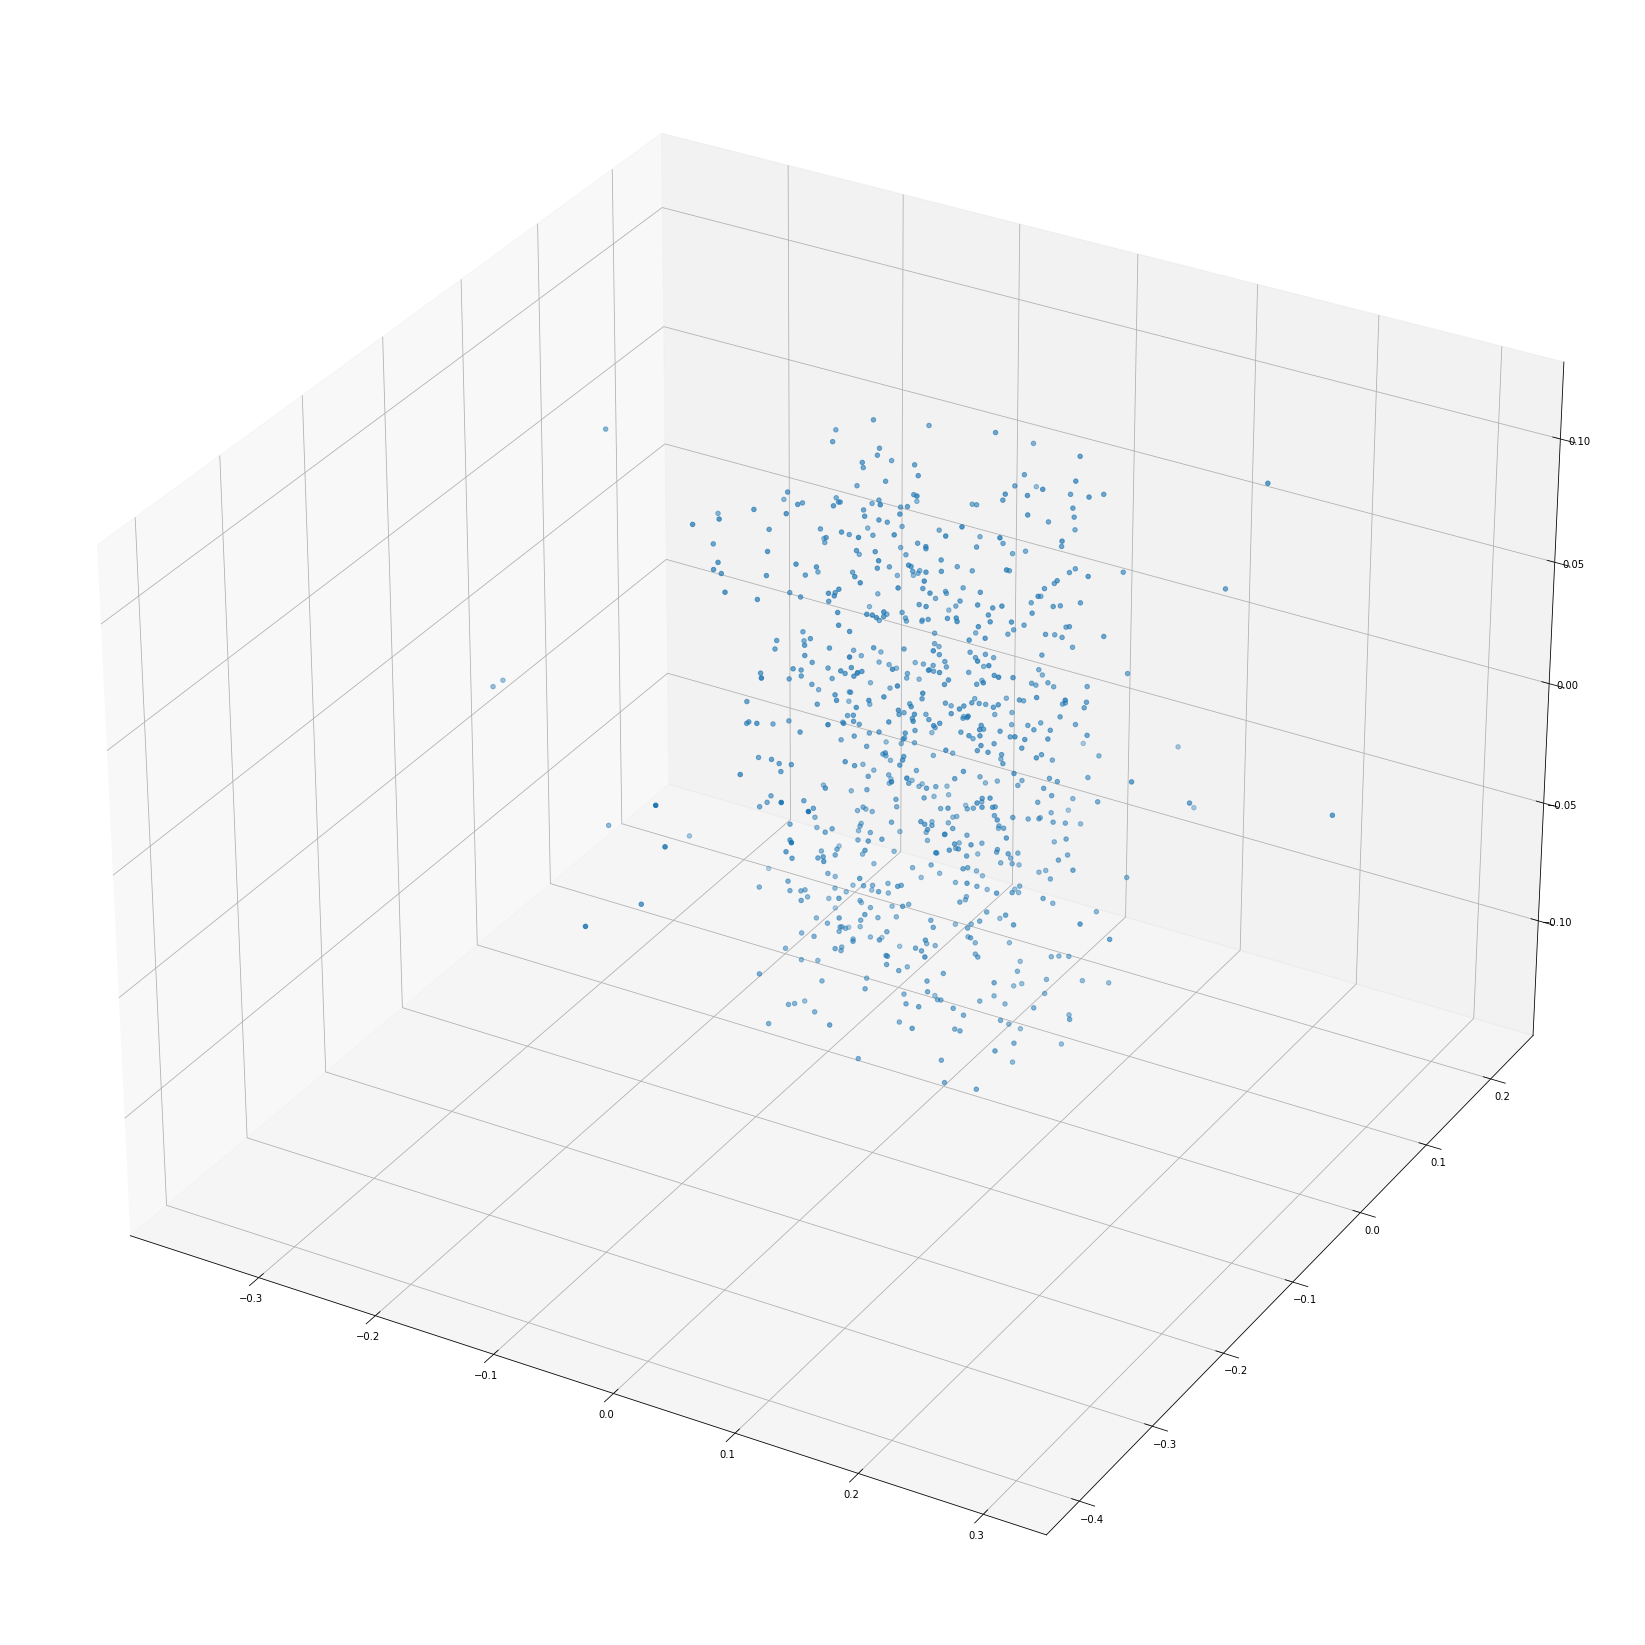

In [81]:
fig, ax = plt.subplots(figsize=(30,30), subplot_kw={"projection": "3d"})

ax.scatter(out_x.detach().numpy(), out_y.detach().numpy(), out_z.detach().numpy())
# ax.scatter(x,y,z)
# ax.scatter(data.y[0, :], data.y[1, :], data.y[2, :])